In [2]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'Anomaly/data/NAB'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [3]:
import torch
import torch.utils.data
from torch.utils.data import DataLoader
import torchvision.transforms as T

from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets
from torchvision.utils import save_image
from torch.utils.data import sampler
import matplotlib.pyplot as plt

import numpy as np
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict

In [4]:
USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():

    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cpu


In [5]:
%cd /content/drive/My\ Drive/Anomaly/data/NAB

/content/drive/My Drive/Anomaly/data/NAB


In [6]:
# Plot data
%matplotlib inline

import warnings
import itertools
import pandas
import math
import sys
import os
import numpy as np
from plotly.offline import download_plotlyjs, plot, iplot
import plotly.io as pio
pio.renderers.default = 'colab'

# data_file_list = ["./data/realTweets/Twitter_volume_AAPL.csv",
#              "./data/realTweets/Twitter_volume_AMZN.csv",
#              "./data/realTweets/Twitter_volume_CRM.csv",
#              "./data/realTweets/Twitter_volume_CVS.csv",
#              "./data/realTweets/Twitter_volume_FB.csv",
#              "./data/realTweets/Twitter_volume_GOOG.csv",
#              "./data/realTweets/Twitter_volume_IBM.csv",
#              "./data/realTweets/Twitter_volume_KO.csv",
#              "./data/realTweets/Twitter_volume_PFE.csv",
#              "./data/realTweets/Twitter_volume_UPS.csv"]

data_file_list = ["./data/realAdExchange/exchange-2_cpc_results.csv",
                  "./data/realAdExchange/exchange-2_cpm_results.csv"]

for data_file in data_file_list:
  Error = None
  if os.path.isfile(data_file):
      dataframe = pandas.read_csv(data_file)
  else:
      Error = "No such file : "+data_file
      print(Error)
  if set(['timestamp','value']).issubset(dataframe.columns) and Error is None:
      x = np.array(dataframe['timestamp'])
      print('Number of samples: ', x.shape[0])
      y = np.array(dataframe['value'])
      mean = np.mean(y)

      trace = {"x": x,
              "y": y,
              "mode": 'lines',
              "name": 'Value'}
      trace_mean = {"x": x,
                    "y": np.ones(len(x))*mean,
                    "mode": 'lines',
                    "name": 'Mean'}
      traces = [trace,trace_mean]
      layout = dict(title = "Data plot : "+data_file,
                    xaxis = dict(title = 'X'),
                    yaxis = dict(title = 'Value')
                  )
      fig = dict(data=traces, layout=layout)
      iplot(fig)
      
  else:
      if Error is None:
          Error = "Missing colomns in file "+data_file
      print(Error)

Number of samples:  1624


Number of samples:  1624


In [7]:
# Fallen layer hidden variable
class Flatten(nn.Module):
  def forward(self, x):
    N = x.shape[0]
    # print(x.shape)
    return x.reshape(N, -1)

class Flatten_inverse(nn.Module):
  def __init__(self, shape):
    super().__init__()
    self.shape = shape
  def forward(self, x):
    return x.view(self.shape)

In [10]:
# VAE
class VAE(nn.Module):
  def __init__(self, 
               hidden_var, 
               L_in, 
               C):
    
    super().__init__()
    self.L_in , self.C = L_in, C
    self.hidden_var =  hidden_var
    
    self.encoder = nn.Sequential(
        Flatten(),
        nn.Linear(L_in*C, 128),
        nn.LeakyReLU(),
        nn.Linear(128, 256),
        nn.LeakyReLU(),
        nn.Linear(256, 512),
        nn.LeakyReLU(),
        nn.Linear(512, self.hidden_var)
    )
    self.decoder = nn.Sequential(
        nn.Linear(self.hidden_var, 512),
        nn.LeakyReLU(),
        nn.Linear(512, 256),
        nn.LeakyReLU(),
        nn.Linear(256, 128),
        nn.LeakyReLU(),
        nn.Linear(128, L_in*C),
        Flatten_inverse((-1, C, L_in))
    )

  def reparameter(self, x):
    self.muy = x[:, 0:self.hidden_var]
    self.log_var = x[:, self.hidden_var:]
    epsilon = torch.empty(1,self.muy.size()[1], device=device).normal_(0.0, 1.0)
    # print(epsilon.shape)
    z = self.muy + self.log_var*epsilon
    return z

  def forward(self, x):
    self.h = self.encoder(x)
    # z = self.reparameter(h)
    x_hat = self.decoder(self.h)

    return x_hat, self.h, self.L_in
  

In [11]:
# Test forward path for AE
N = 64
C = 2
L = 32
H = 32
vae = VAE(H, L, C).to(device=device)
print(vae(torch.rand((N, C, L)).to(device))[0].shape)

torch.Size([64, 2, 32])


In [12]:
# Prepare data for training
data_file_list = ["./data/realAdExchange/exchange-2_cpc_results.csv",
                  "./data/realAdExchange/exchange-2_cpm_results.csv"]
X_train = None
for data_file in data_file_list:
  Error = None

  if os.path.isfile(data_file):
      dataframe = pandas.read_csv(data_file)
  else:
      Error = "No such file : "+data_file
      print(Error)
  if set(['timestamp','value']).issubset(dataframe.columns) and Error is None:
      x = np.array(dataframe['value'])
      print('Number of samples: ', x.shape[0])
      if X_train == None:
        X_train = torch.from_numpy(x.reshape(1,1,-1).astype(np.float32))
      else:
        X_train = torch.cat((X_train, torch.from_numpy(x.reshape(1, 1, -1).astype(np.float32))), dim=1)
  else:
      if Error is None:
          Error = "Missing colomns in file "+data_file
      print(Error)
X_test = X_train[:,:,1400:1623]
X_train= X_train[:,:,0   :1400]
print(X_train.shape)

Number of samples:  1624
Number of samples:  1624
torch.Size([1, 2, 1400])


In [23]:
# Loss function
def loss_fn(x, x_hat, muy, log_var, alpha):
  reconstruction_loss = torch.mean((x - x_hat)**2)
  # KLD_loss = -0.5*torch.sum(1 + log_var - muy**2 - log_var.exp())
  # reconstruction_total = reconstruction_loss/(alpha*KLD_loss)
  loss = reconstruction_loss# + alpha*KLD_loss
  return loss#, reconstruction_total

In [24]:
# Overfit a sample 
def train_overfit(model, opt, reg=0.01, max_iteration=100, sample_length=32):
  model.to(device)
  sample = X_train[:,:,0:sample_length].to(device=device, dtype=dtype)
  model.train()
  loss_hist = []
  muy_hist = []
  logvar_hist = []
  for iter in range(max_iteration):
    x_hat, muy, log_var = model(sample)
    loss = loss_fn(sample, x_hat, muy, log_var, reg)
    loss.backward()
    opt.step()
    opt.zero_grad()
    loss_hist.append(loss.item())
  plt.plot(list(np.arange(len(loss_hist))), loss_hist)
  plt.show()


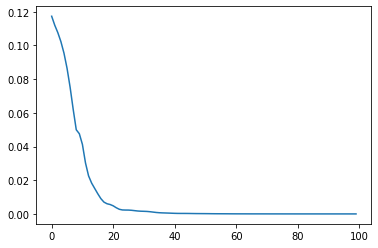

In [26]:
N = 64
C = 2
L = 64
H = 20

vae = VAE(H, L, C)
# Optimizer for overfit tranning
optim = torch.optim.Adam(vae.parameters(), lr=1e-3)
train_overfit(vae, optim, max_iteration=100, sample_length=L)
# print(vae.muy)
# print(vae.log_var)

In [27]:
def train(model, opt, alpha=0.01, epochs=1, sample_length=32, batch_size=32):
  model.to(device)
  model.train()
  sample = torch.zeros((batch_size, 2, sample_length)).to(device=device, dtype=dtype)
  L = X_train.shape[2]
  loss_hist = []
  muy_hist = []
  min_loss = 1000
  for e in range(epochs):
    for iter in range(int(X_train.shape[2]/batch_size)):
      for i in range(batch_size):
        start = np.random.randint(0,L - sample_length)
        sample[i,:,:] = X_train[0,:,start:start + sample_length]
      x_hat, muy, log_var = model(sample)
      loss = loss_fn(sample, x_hat, muy, log_var, alpha)
      loss.backward()
      opt.step()
      opt.zero_grad()
      if loss.item() < min_loss:
        min_loss = loss.item()
      if loss_hist:
        loss_hist.append(loss.item()*0.1 + loss_hist[-1]*0.9)
      else:
        loss_hist.append(loss.item())
      # muy_hist.append(muy_hist[-1]*0.9 + muy)
    print('epoch: ', e, ' min loss = ', min_loss, 'evg loss ', loss_hist[-1])
    plt.plot(list(np.arange(len(loss_hist))), loss_hist)
    plt.show()

In [28]:
N = 64
C = 2
L = 64
H = 128

vae = VAE(H, L, C)


In [29]:
optim = torch.optim.Adam(vae.parameters(), lr=5e-4)

epoch:  0  min loss =  0.01905718445777893 evg loss  0.03829679955899554


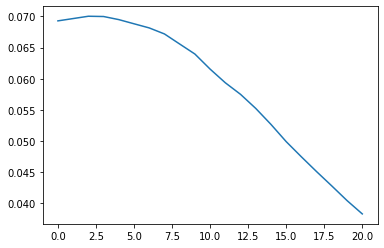

epoch:  1  min loss =  0.013093641959130764 evg loss  0.016616362461242852


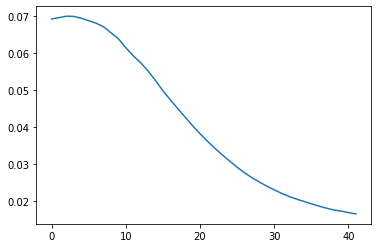

epoch:  2  min loss =  0.012056095525622368 evg loss  0.013270989792949234


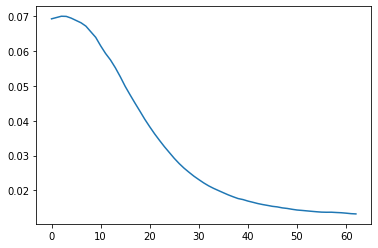

epoch:  3  min loss =  0.012056095525622368 evg loss  0.01298843822320673


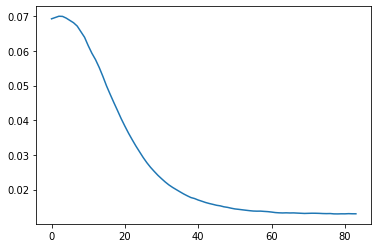

epoch:  4  min loss =  0.011593515984714031 evg loss  0.012535853546078453


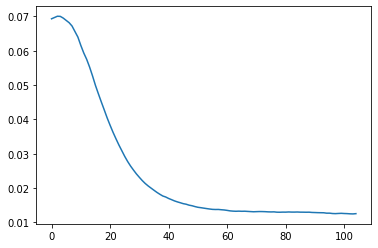

epoch:  5  min loss =  0.009636598639190197 evg loss  0.010821171605605858


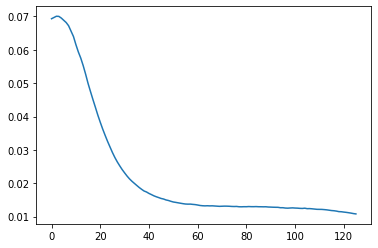

epoch:  6  min loss =  0.005481672007590532 evg loss  0.007614517763352889


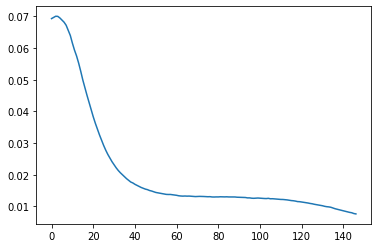

epoch:  7  min loss =  0.0030852900817990303 evg loss  0.00452696514956174


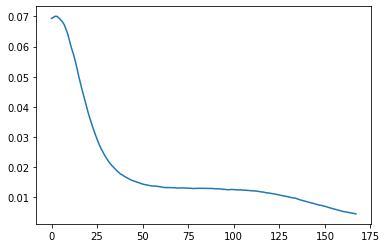

epoch:  8  min loss =  0.00302557903341949 evg loss  0.003542960060372984


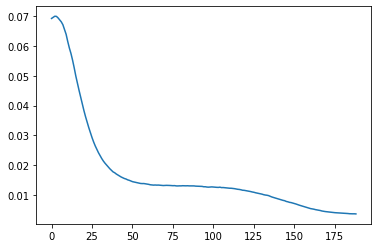

epoch:  9  min loss =  0.0025339783169329166 evg loss  0.0030687796975845338


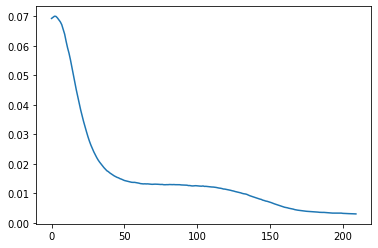

epoch:  10  min loss =  0.002455152804031968 evg loss  0.0027896406092867195


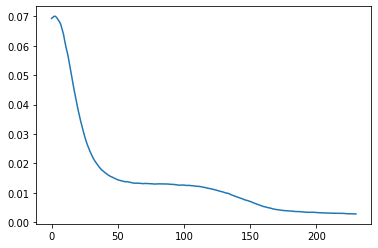

epoch:  11  min loss =  0.002368528861552477 evg loss  0.002746742875719141


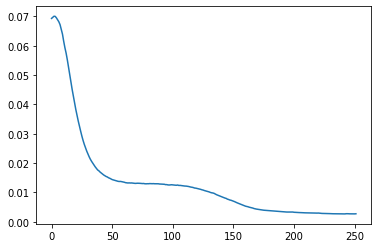

epoch:  12  min loss =  0.002368528861552477 evg loss  0.0026745967642783234


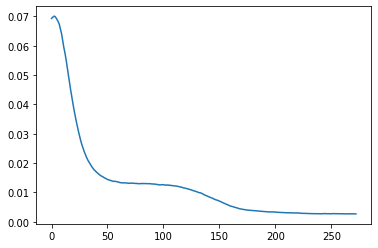

epoch:  13  min loss =  0.0022897860035300255 evg loss  0.0026326626934896256


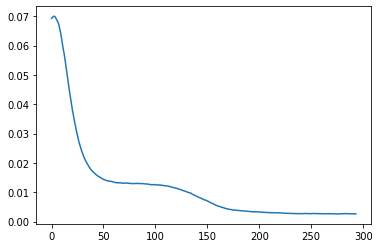

epoch:  14  min loss =  0.0022872777190059423 evg loss  0.0026321383631863387


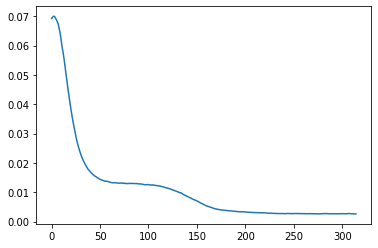

epoch:  15  min loss =  0.0022872777190059423 evg loss  0.002597114868957898


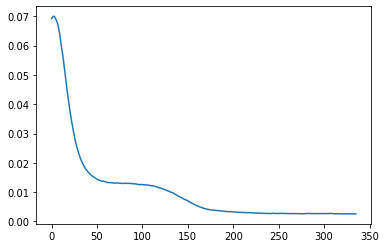

epoch:  16  min loss =  0.0022872777190059423 evg loss  0.0025694822141766344


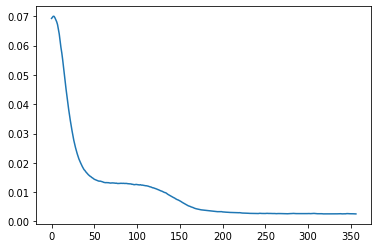

epoch:  17  min loss =  0.002207797486335039 evg loss  0.002571202791341873


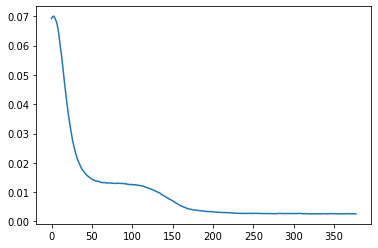

epoch:  18  min loss =  0.002207797486335039 evg loss  0.0025686339281787538


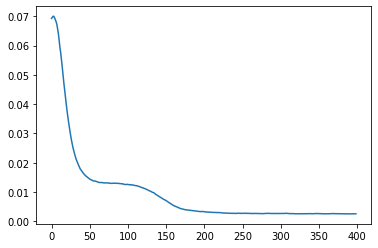

epoch:  19  min loss =  0.002207797486335039 evg loss  0.002677660063524067


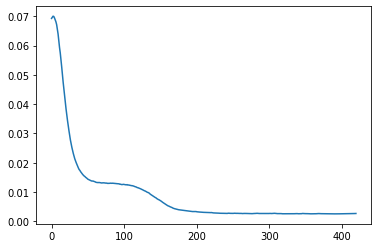

epoch:  20  min loss =  0.002207797486335039 evg loss  0.002580537691667941


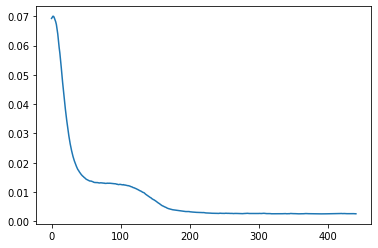

epoch:  21  min loss =  0.002164041856303811 evg loss  0.00255620959511458


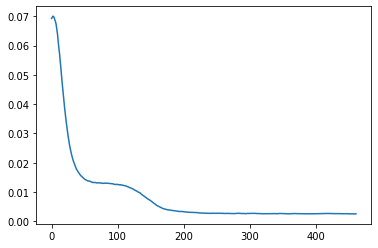

epoch:  22  min loss =  0.002164041856303811 evg loss  0.002612133956675819


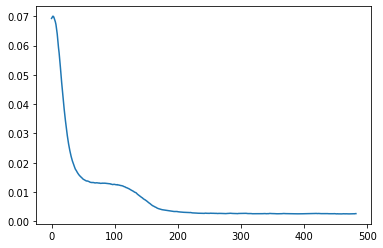

epoch:  23  min loss =  0.002164041856303811 evg loss  0.00254719433669836


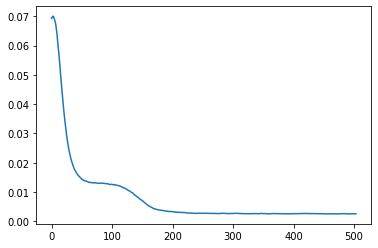

epoch:  24  min loss =  0.002090754918754101 evg loss  0.002491312007568619


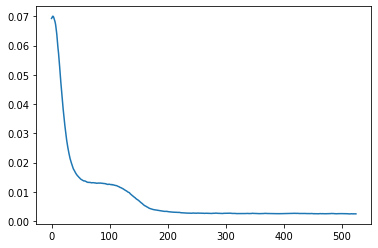

epoch:  25  min loss =  0.002090754918754101 evg loss  0.002524648784400369


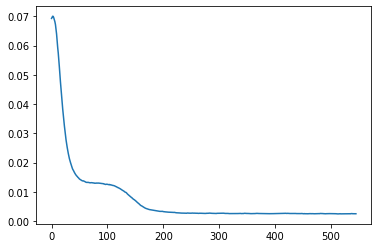

epoch:  26  min loss =  0.002090754918754101 evg loss  0.0024353856528622846


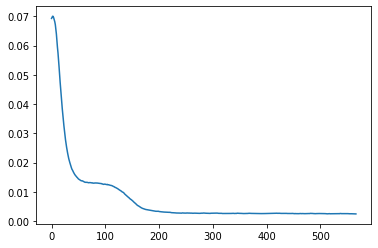

epoch:  27  min loss =  0.002090754918754101 evg loss  0.0025134248189344964


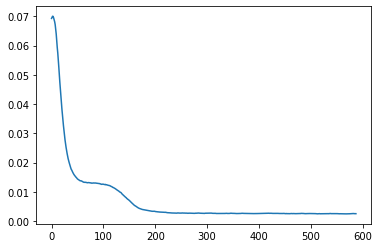

epoch:  28  min loss =  0.002090754918754101 evg loss  0.0025518527780195224


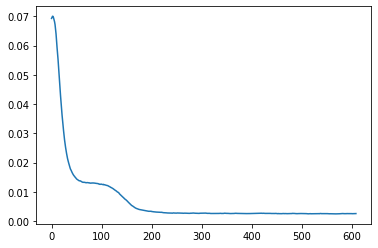

epoch:  29  min loss =  0.002090754918754101 evg loss  0.002556966421962015


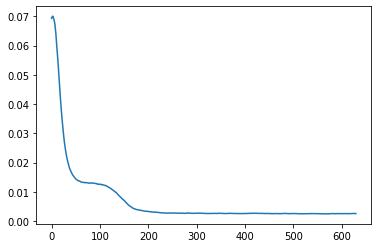

epoch:  30  min loss =  0.002090754918754101 evg loss  0.002535177866075144


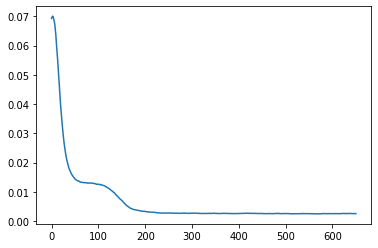

epoch:  31  min loss =  0.002090754918754101 evg loss  0.0024611691949814204


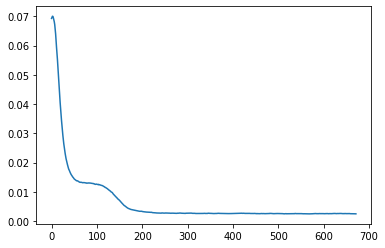

epoch:  32  min loss =  0.002090754918754101 evg loss  0.0024980515034346367


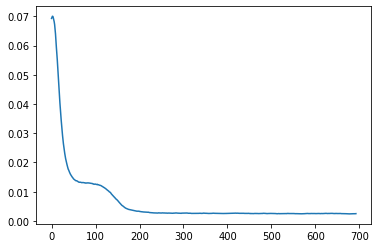

epoch:  33  min loss =  0.002090754918754101 evg loss  0.002552578543297349


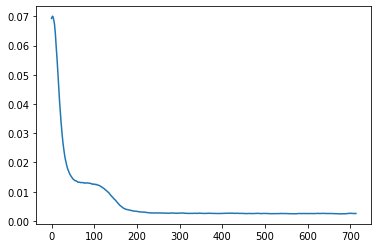

epoch:  34  min loss =  0.002090754918754101 evg loss  0.0024939620195718296


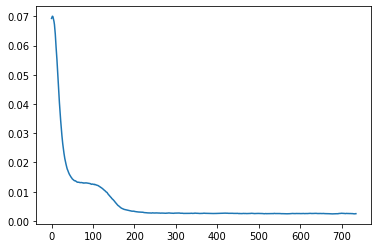

epoch:  35  min loss =  0.002056708326563239 evg loss  0.00249282298206953


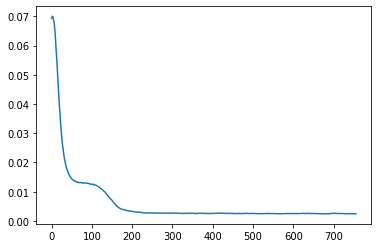

epoch:  36  min loss =  0.002056708326563239 evg loss  0.002475621563925124


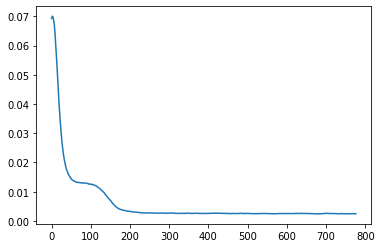

epoch:  37  min loss =  0.002056708326563239 evg loss  0.002471479028532731


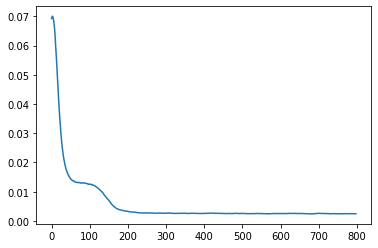

epoch:  38  min loss =  0.002056708326563239 evg loss  0.0023915260139058822


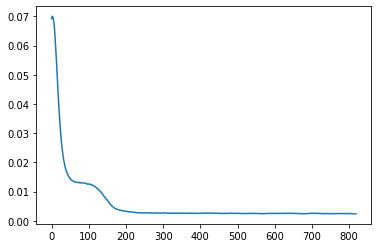

epoch:  39  min loss =  0.002056708326563239 evg loss  0.0025071619916486212


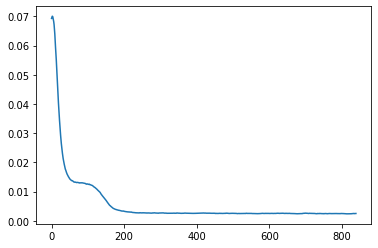

epoch:  40  min loss =  0.002056708326563239 evg loss  0.002408314083802532


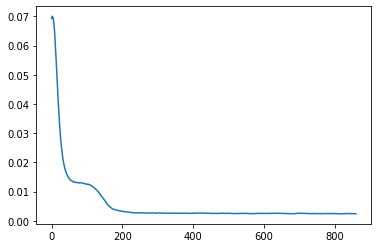

epoch:  41  min loss =  0.002056708326563239 evg loss  0.0024400157430671658


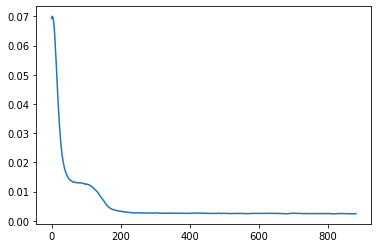

epoch:  42  min loss =  0.0019876351580023766 evg loss  0.0023973218216170535


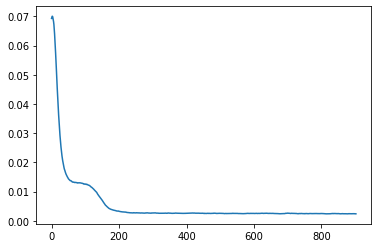

epoch:  43  min loss =  0.0019876351580023766 evg loss  0.002528421625366009


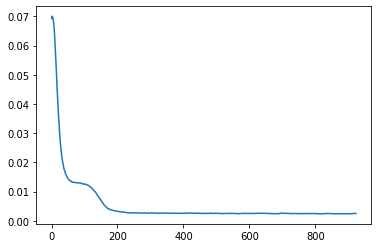

epoch:  44  min loss =  0.0019876351580023766 evg loss  0.0024849194209189047


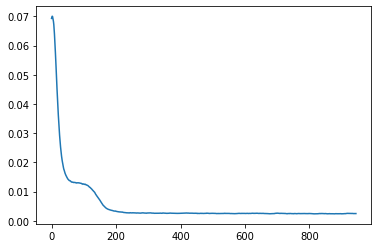

epoch:  45  min loss =  0.0019876351580023766 evg loss  0.0024686550771266607


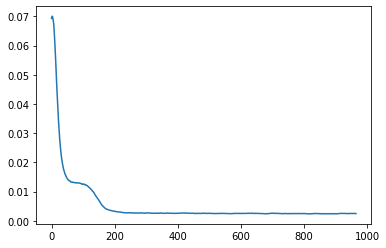

epoch:  46  min loss =  0.0019876351580023766 evg loss  0.0023732055197520506


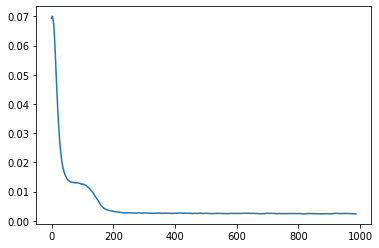

epoch:  47  min loss =  0.0019876351580023766 evg loss  0.002364070699534567


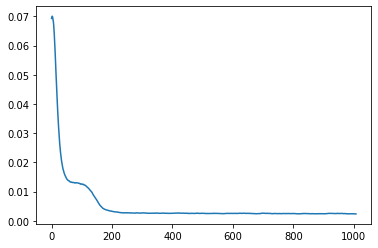

epoch:  48  min loss =  0.0019876351580023766 evg loss  0.0024563987098907805


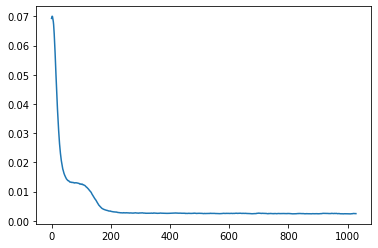

epoch:  49  min loss =  0.0017509706085547805 evg loss  0.002398748511253052


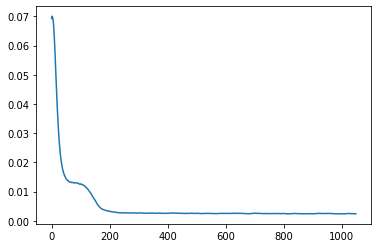

epoch:  50  min loss =  0.0017509706085547805 evg loss  0.0024214075000870867


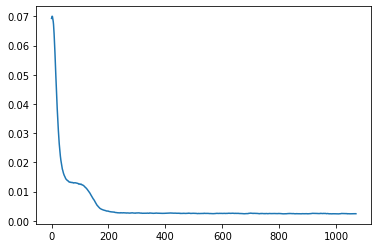

epoch:  51  min loss =  0.0017509706085547805 evg loss  0.0022931020176736815


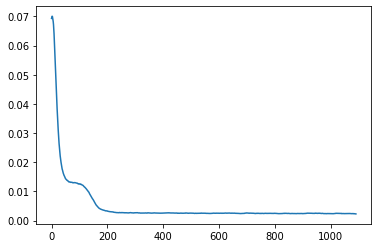

epoch:  52  min loss =  0.0017509706085547805 evg loss  0.002271496271656524


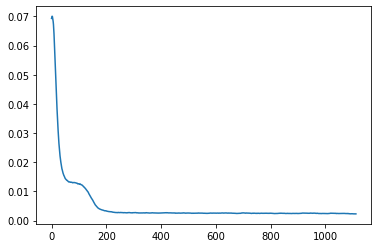

epoch:  53  min loss =  0.0017509706085547805 evg loss  0.002359262111662449


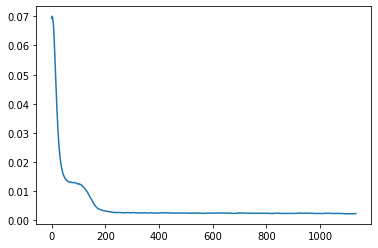

epoch:  54  min loss =  0.0017509706085547805 evg loss  0.002312654693190367


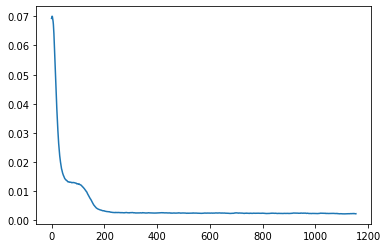

epoch:  55  min loss =  0.0017509706085547805 evg loss  0.002300754066637792


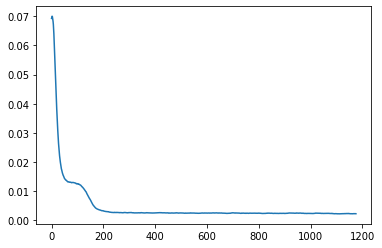

epoch:  56  min loss =  0.0017509706085547805 evg loss  0.002372529958016912


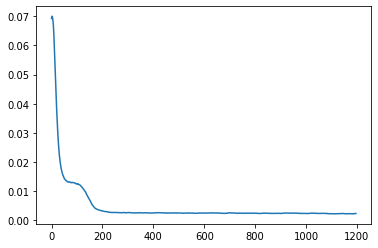

epoch:  57  min loss =  0.0017509706085547805 evg loss  0.002297167247982213


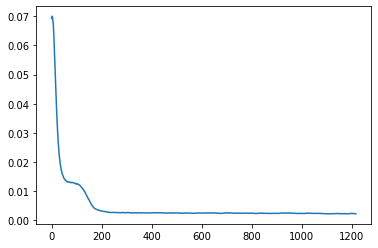

epoch:  58  min loss =  0.0017509706085547805 evg loss  0.0022581944150986753


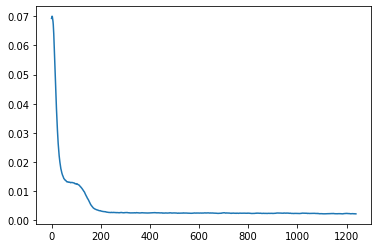

epoch:  59  min loss =  0.0017509706085547805 evg loss  0.002353935372384844


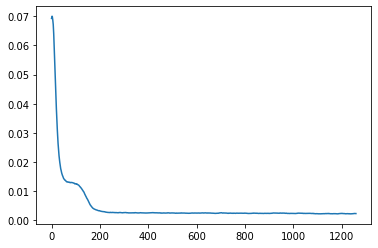

epoch:  60  min loss =  0.0017509706085547805 evg loss  0.002258521044912134


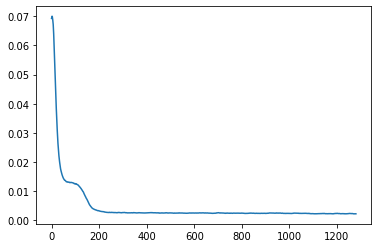

epoch:  61  min loss =  0.0017509706085547805 evg loss  0.0022698450722027576


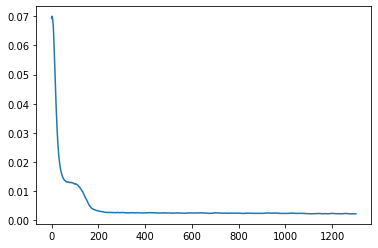

epoch:  62  min loss =  0.0017509706085547805 evg loss  0.0022371451547012655


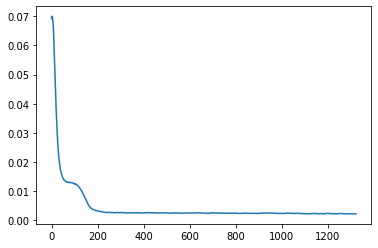

epoch:  63  min loss =  0.0017509706085547805 evg loss  0.0022139826837811625


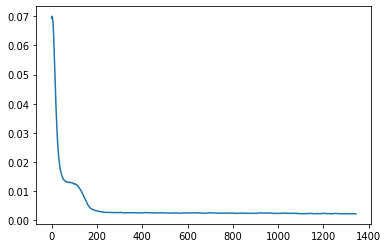

epoch:  64  min loss =  0.0017509706085547805 evg loss  0.0021773841676955607


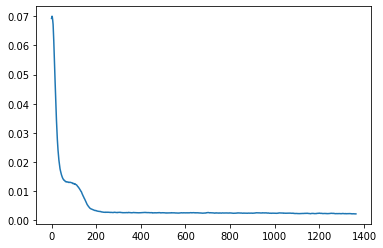

epoch:  65  min loss =  0.0017509706085547805 evg loss  0.002163777562063253


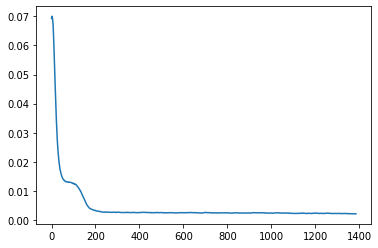

epoch:  66  min loss =  0.0017509706085547805 evg loss  0.0021166646197165115


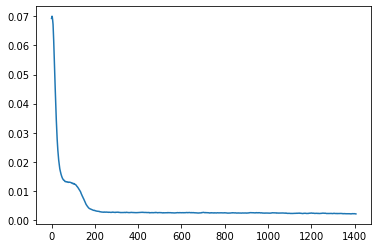

epoch:  67  min loss =  0.0017509706085547805 evg loss  0.0021509962881558703


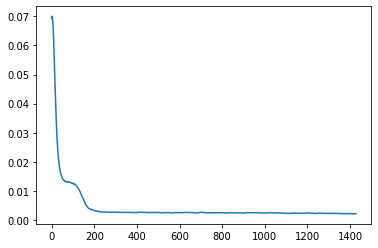

epoch:  68  min loss =  0.0017509706085547805 evg loss  0.00214922368938498


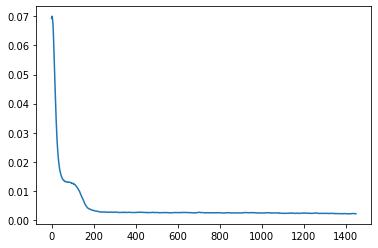

epoch:  69  min loss =  0.0017509706085547805 evg loss  0.002171610478617831


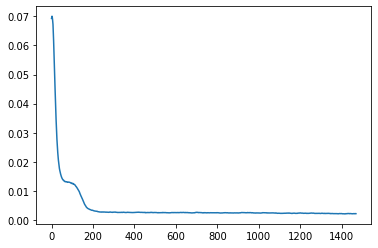

epoch:  70  min loss =  0.0017509706085547805 evg loss  0.002199759165006684


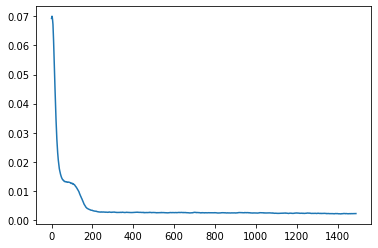

epoch:  71  min loss =  0.0017509706085547805 evg loss  0.00215294944155412


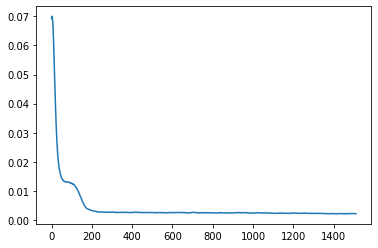

epoch:  72  min loss =  0.0017509706085547805 evg loss  0.0021635544644671378


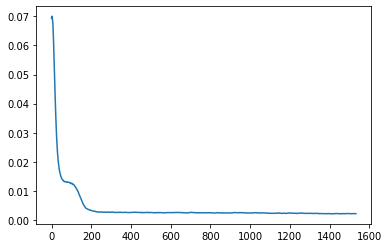

epoch:  73  min loss =  0.0017509706085547805 evg loss  0.0020986347376273874


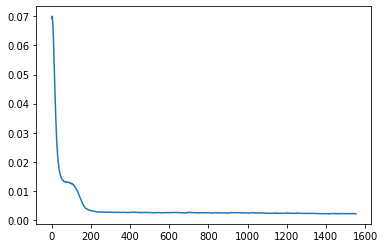

epoch:  74  min loss =  0.0017509706085547805 evg loss  0.002102787227298345


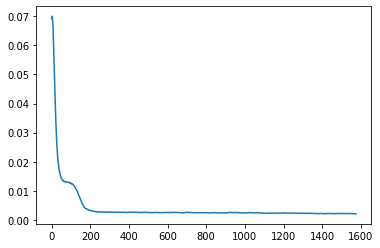

epoch:  75  min loss =  0.0017509706085547805 evg loss  0.0021506078975944897


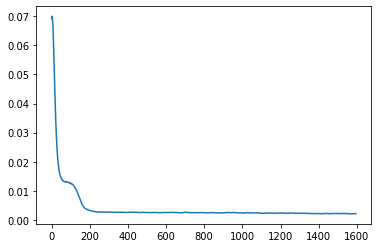

epoch:  76  min loss =  0.0017358909826725721 evg loss  0.002099998490036857


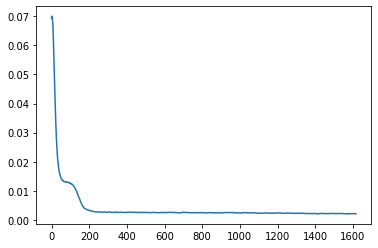

epoch:  77  min loss =  0.0017358909826725721 evg loss  0.002189765670662488


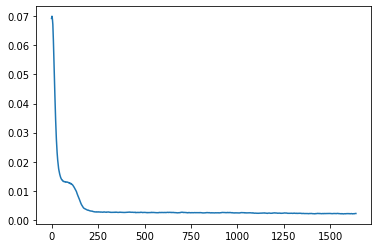

epoch:  78  min loss =  0.0017358909826725721 evg loss  0.0021320009330059947


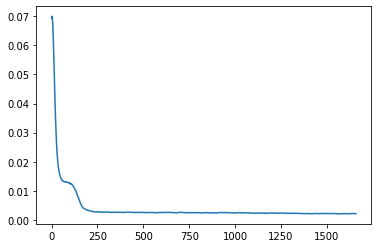

epoch:  79  min loss =  0.0017284040804952383 evg loss  0.0020874487367144342


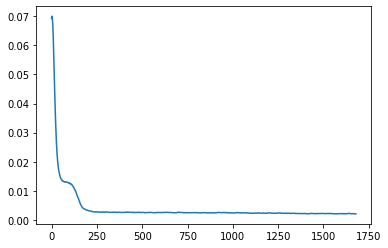

epoch:  80  min loss =  0.0017284040804952383 evg loss  0.0021278405716454512


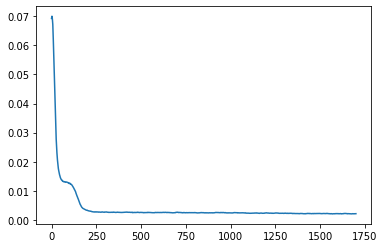

epoch:  81  min loss =  0.0017284040804952383 evg loss  0.0020702508969407127


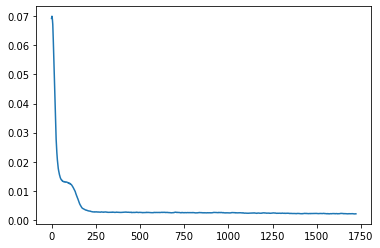

epoch:  82  min loss =  0.0017284040804952383 evg loss  0.002072312459599175


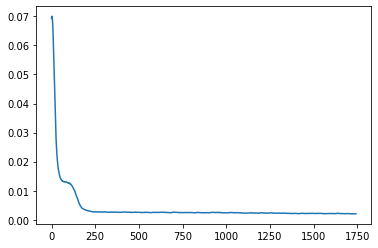

epoch:  83  min loss =  0.0017140023410320282 evg loss  0.002030488752071266


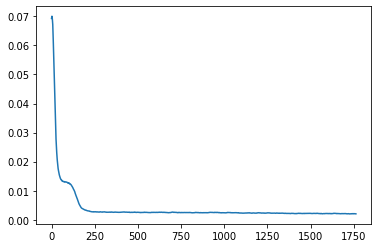

epoch:  84  min loss =  0.0017140023410320282 evg loss  0.002052297403937418


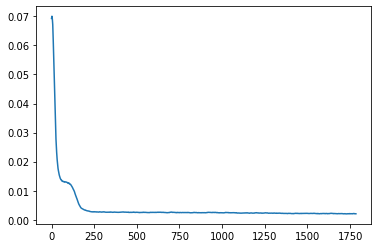

epoch:  85  min loss =  0.0017085601575672626 evg loss  0.002129216785564948


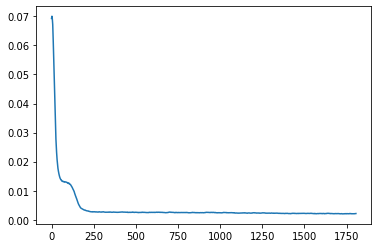

epoch:  86  min loss =  0.0017085601575672626 evg loss  0.001977008900818361


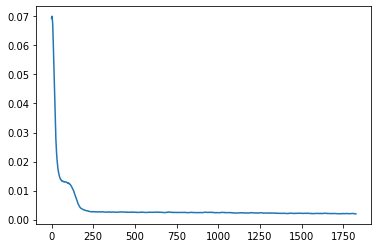

epoch:  87  min loss =  0.0017085601575672626 evg loss  0.002007344491176527


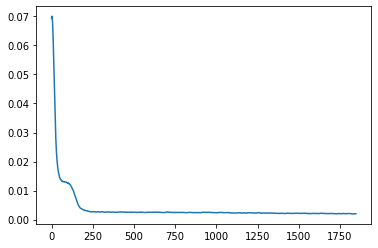

epoch:  88  min loss =  0.0017085601575672626 evg loss  0.002039075103661163


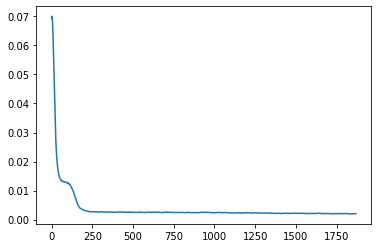

epoch:  89  min loss =  0.0016976525075733662 evg loss  0.002032826438072578


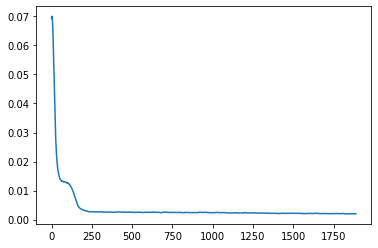

epoch:  90  min loss =  0.0016976525075733662 evg loss  0.0020403741258497514


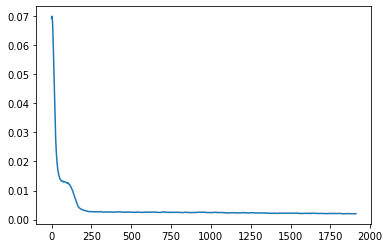

epoch:  91  min loss =  0.0016976525075733662 evg loss  0.0020462839694349736


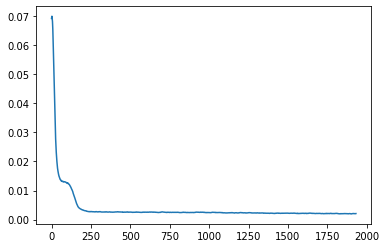

epoch:  92  min loss =  0.0016976525075733662 evg loss  0.002072174800964165


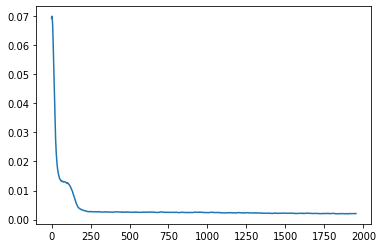

epoch:  93  min loss =  0.0016976525075733662 evg loss  0.0020529852141088945


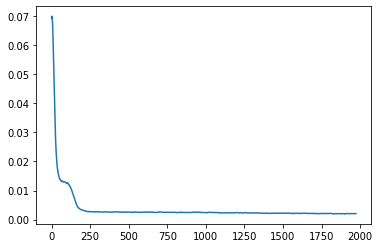

epoch:  94  min loss =  0.0016069809207692742 evg loss  0.0019893355480676213


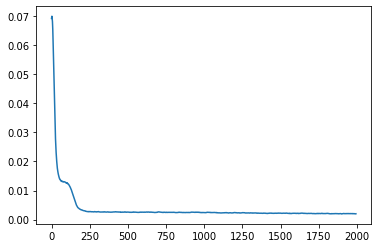

epoch:  95  min loss =  0.0016069809207692742 evg loss  0.0019870223458655183


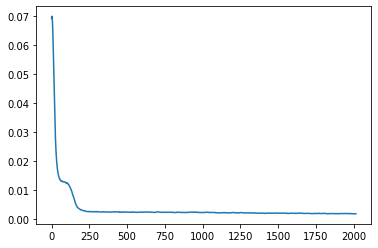

epoch:  96  min loss =  0.0016069809207692742 evg loss  0.0019354619898870294


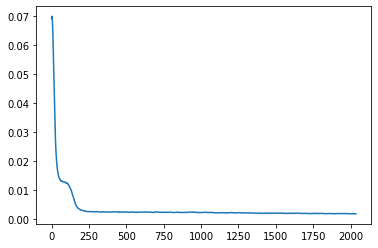

epoch:  97  min loss =  0.0016069809207692742 evg loss  0.002040470759805431


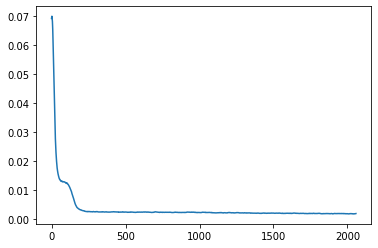

epoch:  98  min loss =  0.0016069809207692742 evg loss  0.002016331319700072


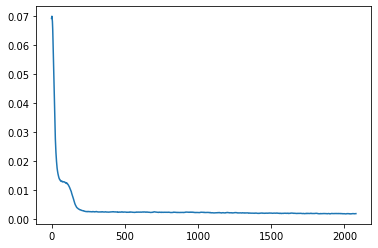

epoch:  99  min loss =  0.0016069809207692742 evg loss  0.00200048405819209


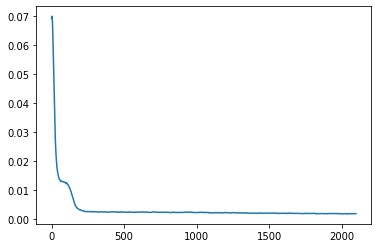

In [30]:
train(vae, optim, epochs=100, alpha=0.01, batch_size=N, sample_length=L)

In [31]:
X_reconstruct = torch.zeros_like(X_test)
vae.to(device)
for i in range(int(X_test.shape[2]/L)-1):
  X_reconstruct[0,:,i*L:i*L+L], _, _ = vae(
      X_test[0,:,i*L:(i+1)*L].reshape(-1,2,L).to(device=device, dtype=dtype)
  )
print(X_reconstruct.shape)

torch.Size([1, 2, 223])


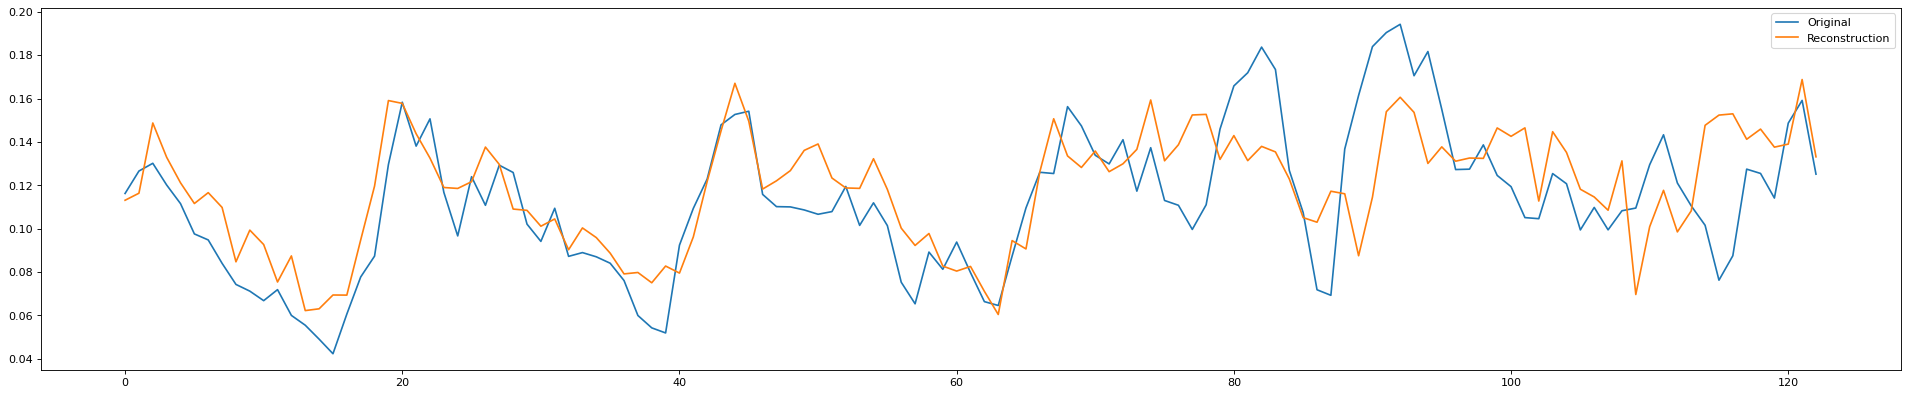

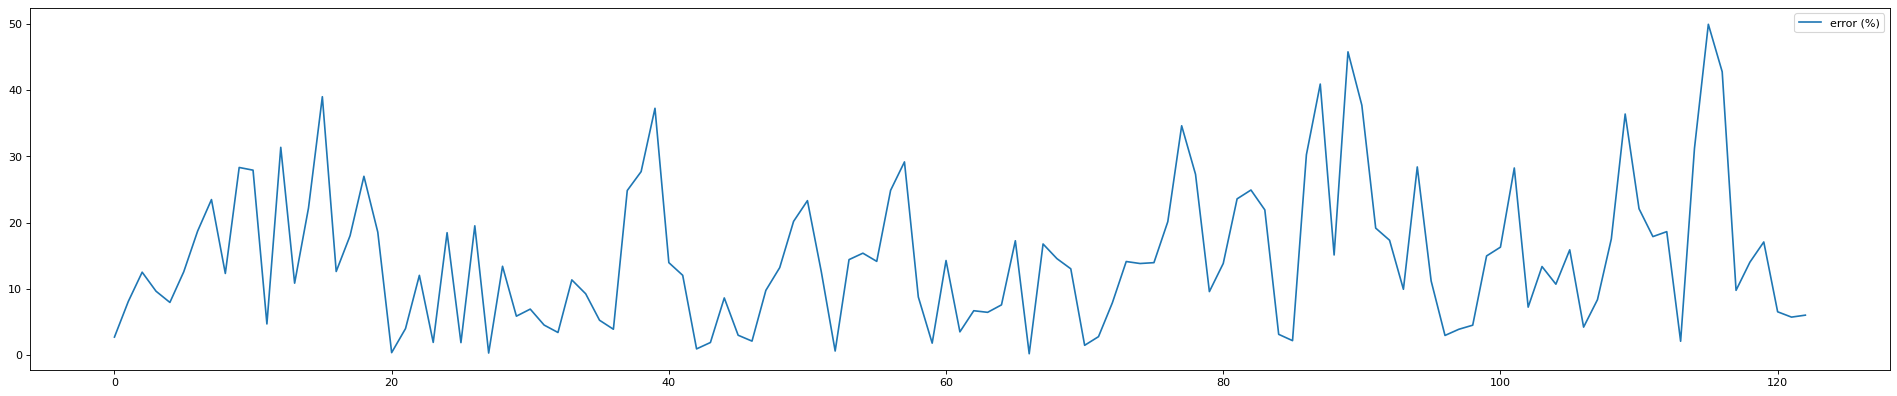

In [32]:
fig=plt.figure(figsize=(30,6), dpi=80)
plt.plot(np.arange(X_test.shape[2]-100), X_test[0,0,:-100].detach().numpy(), label='Original')
# plt.legend()
# plt.show()
# fig=plt.figure(figsize=(30,6), dpi=80)

plt.plot(np.arange(X_reconstruct.shape[2]-100), X_reconstruct[0,0,:-100].detach().numpy(), label='Reconstruction')
plt.legend()
plt.show()
fig=plt.figure(figsize=(30,6), dpi=80)
error = 100*torch.abs(X_reconstruct[0,0,:-100] - X_test[0,0,:-100])/torch.max(X_reconstruct[0,0,:-100], X_test[0,0,:-100])
plt.plot(np.arange(X_reconstruct.shape[2]-100), error.detach().numpy(), label='error (%)')
plt.legend()
plt.show()

torch.Size([1, 2, 1400])


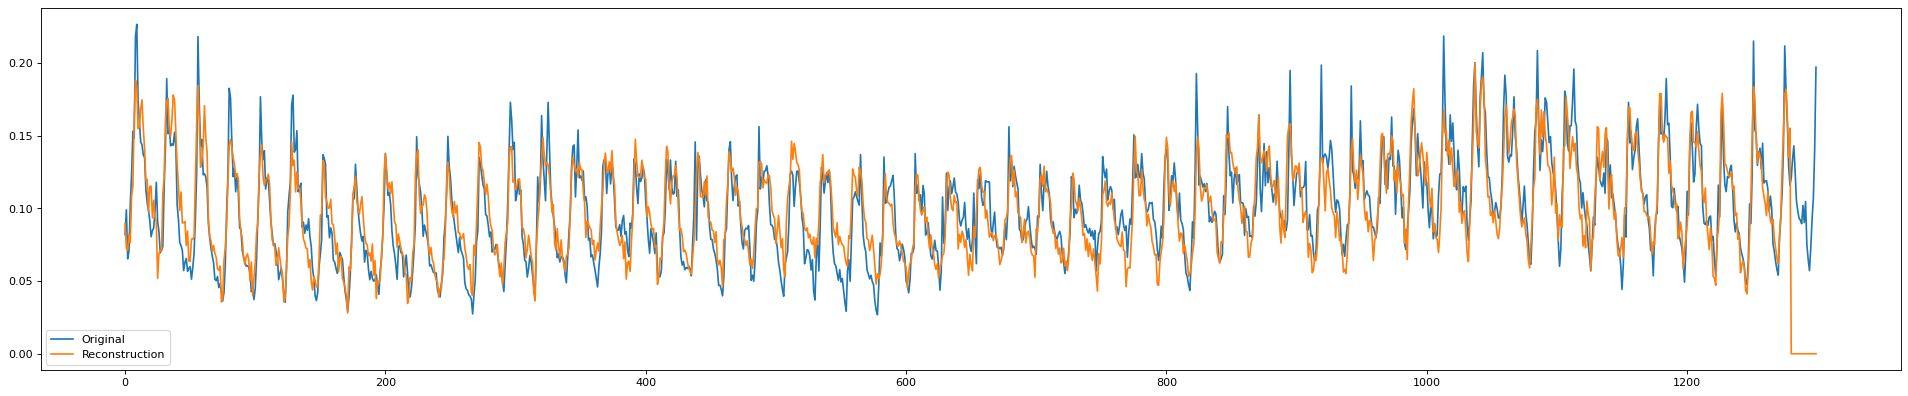

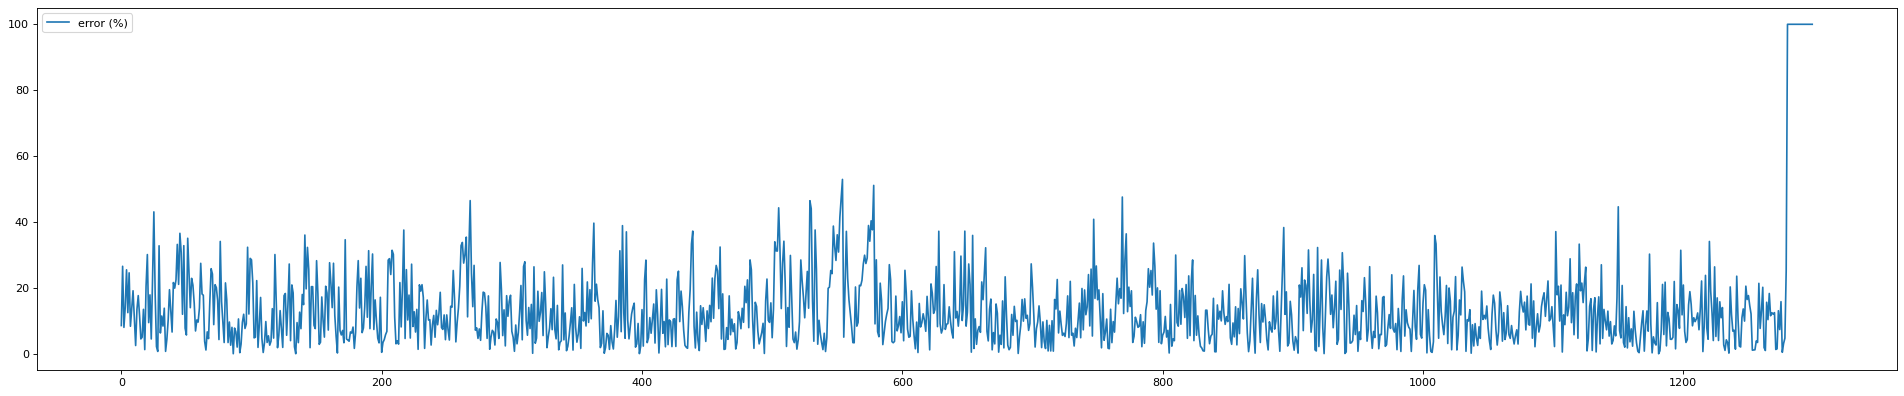

In [33]:
X_reconstruct = torch.zeros_like(X_train)
vae.to(device)
for i in range(int(X_train.shape[2]/L)-1):
  X_reconstruct[0,:,i*L:i*L+L], _, _ = vae(
      X_train[0,:,i*L:(i+1)*L].reshape(-1,2,L).to(device=device, dtype=dtype)
  )
print(X_reconstruct.shape)
fig=plt.figure(figsize=(30,6), dpi=80)
plt.plot(np.arange(X_train.shape[2]-100), X_train[0,0,:-100].detach().numpy(), label='Original')
# plt.legend()
# plt.show()
# fig=plt.figure(figsize=(30,6), dpi=80)

plt.plot(np.arange(X_reconstruct.shape[2]-100), X_reconstruct[0,0,:-100].detach().numpy(), label='Reconstruction')
plt.legend()
plt.show()
fig=plt.figure(figsize=(30,6), dpi=80)
error = 100*torch.abs(X_reconstruct[0,0,:-100] - X_train[0,0,:-100])/torch.max(X_reconstruct[0,0,:-100], X_train[0,0,:-100])
plt.plot(np.arange(X_reconstruct.shape[2]-100), error.detach().numpy(), label='error (%)')
plt.legend()
plt.show()